<a href="https://colab.research.google.com/github/VVlovsky/breast_cancer_logistic_regression/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regresja logistyczna do wyliczania prawdopodobienstwa powrotu raka pierszi. 

**Autorzy**: 
- Vyacheslav Trushkov
- Dmytro Kuzmin

**Motywacja**: napisanie algorytmu który po otrzymaniu zbioru dannych (286 instancji) zrobi predykcje możliwości recydywy raku.

**Dane**: używamy danych z Uniwersyteckiego Centrum Medycznego, Instytut Onkologii, Ljubljana, Jugosławia
- Rozmiar zbioru danych: 286
- Liczba atrybutów: 9

In [640]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt


if not os.path.exists('./breast-cancer.data'):
  !wget https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data
if not os.path.exists('./breast-cancer.names'):
  !wget https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.names

In [641]:
!cat './breast-cancer.names'

Citation Request:
   This breast cancer domain was obtained from the University Medical Centre,
   Institute of Oncology, Ljubljana, Yugoslavia.  Thanks go to M. Zwitter and 
   M. Soklic for providing the data.  Please include this citation if you plan
   to use this database.

1. Title: Breast cancer data (Michalski has used this)

2. Sources: 
   -- Matjaz Zwitter & Milan Soklic (physicians)
      Institute of Oncology 
      University Medical Center
      Ljubljana, Yugoslavia
   -- Donors: Ming Tan and Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
   -- Date: 11 July 1988

3. Past Usage: (Several: here are some)
     -- Michalski,R.S., Mozetic,I., Hong,J., & Lavrac,N. (1986). The 
        Multi-Purpose Incremental Learning System AQ15 and its Testing 
        Application to Three Medical Domains.  In Proceedings of the 
        Fifth National Conference on Artificial Intelligence, 1041-1045,
        Philadelphia, PA: Morgan Kaufmann.
        -- accuracy range: 66%-72%
     -

In [642]:
raw_data = pd.read_csv('./breast-cancer.data', names=['class', 'age', 'menopause', 'tumor_size', 'inv_nodes', 'node_caps', 'deg_malig', 'breast', 'breast_quad', 'irradiat']).sample(frac=1)
raw_data.head()

,class,age,menopause,tumor_size,inv_nodes,node_caps,deg_malig,breast,breast_quad,irradiat
40,no-recurrence-events,50-59,ge40,20-24,0-2,no,1,right,left_low,no
171,no-recurrence-events,30-39,premeno,15-19,0-2,no,1,left,left_low,no
15,no-recurrence-events,60-69,lt40,30-34,0-2,no,1,left,left_low,no
58,no-recurrence-events,60-69,ge40,30-34,0-2,no,1,left,left_up,no
252,recurrence-events,30-39,premeno,40-44,0-2,no,1,left,left_up,no


In [643]:
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat
from scipy import stats
import seaborn as sns # visualize

# Szukamy 2 kolumne z największą korelacja między sobą 
# i dla tych kolumn będziemy obliczać regresju.
def find_most_correlated_cols(df):
  plt.figure(figsize=(10,10))
  sns.heatmap(df.corr(),annot = True, fmt = ".2f",cbar = True, vmin=-1, vmax =1)
  plt.xticks(rotation=90)
  plt.yticks(rotation = 0)
  corr = df.corr()
  corr[corr==1] = 0
  corr[pd.isnull(corr)] = 0
  corr = corr.abs().unstack().sort_values().dropna()
  str_of_cols = str(corr.tail(1)).partition('\n')[0]
  arr_of_cols = (str_of_cols.split(' ', 3)[0], str_of_cols.split(' ', 3)[2])
  print(arr_of_cols)
  return arr_of_cols

In [644]:

dummies = pd.get_dummies(raw_data.menopause)
data = raw_data.join(dummies)
data = data.drop('menopause', axis=1)

dummies = pd.get_dummies(data.breast_quad)
data = data.join(dummies)
data = data.drop('breast_quad', axis=1)
data = data.drop('?', axis=1)

data.node_caps = (data.node_caps == 'yes').astype(int)
data.irradiat = (data.irradiat == 'yes').astype(int)
data['class'] = (data['class'] == 'recurrence-events').astype(int)
data.breast = (data.breast == 'left').astype(int)

data.age = data.age.map(lambda x: np.mean([int(x.split('-')[0]), int(x.split('-')[1])]))
data.tumor_size = data.tumor_size.map(lambda x: np.mean([int(x.split('-')[0]), int(x.split('-')[1])]))
data.inv_nodes = data.inv_nodes.map(lambda x: np.mean([int(x.split('-')[0]), int(x.split('-')[1])]))

data = data.apply(lambda x: (x - x.min()) / ( x.max() - x.min()), axis=0)

data.head()

,class,age,tumor_size,inv_nodes,node_caps,deg_malig,breast,irradiat,ge40,lt40,premeno,central,left_low,left_up,right_low,right_up
40,0.0,0.6,0.4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
171,0.0,0.2,0.3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
15,0.0,0.8,0.6,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
58,0.0,0.8,0.6,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
252,1.0,0.2,0.8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


('premeno', 'ge40')


('premeno', 'ge40')

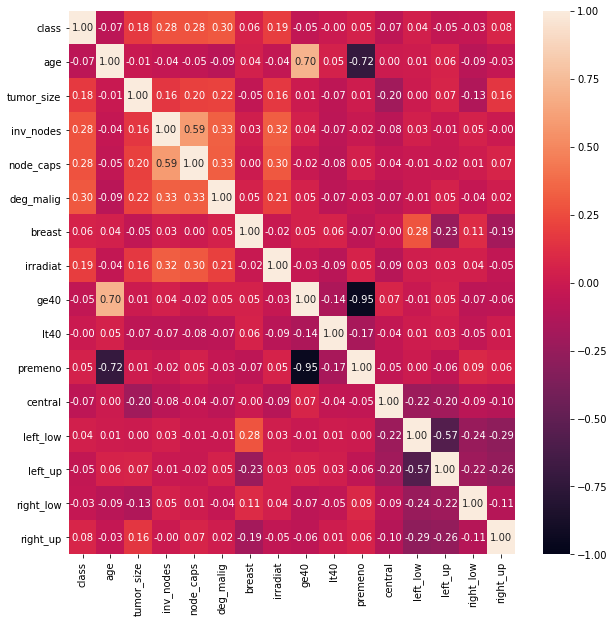

In [645]:
find_most_correlated_cols(data)

In [646]:
to_drop = ['premeno', 'ge40']
data = data.drop(to_drop, axis=1)

Dalej dzielimy dane na **dane testowe** i **dane uczące**. Dane testowe składają 20% od całego zbioru danych.

Maksymalna liczba itercji: 1000000.

In [648]:
y = np.asarray(data['class'].values)
x = np.asarray(data.drop('class', axis=1).values)

In [649]:
acc_arr = []
for i in range(1000):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
  clf = LogisticRegression(solver='liblinear', max_iter=100, penalty='l1', C=0.8)
  clf.fit(x_train, y_train)
  acc_arr.append(clf.score(x_test, y_test))
print(np.mean(acc_arr))

0.7240348837209303


Budujemy heatmap 

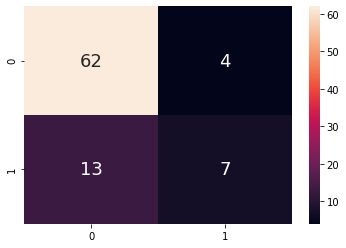

In [650]:
y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sn.heatmap(cm, annot=True, annot_kws={"size": 18})
plt.show()